# Generating Dispersion Diagrams with FenicsX

Josh Tempelman

University of Illinois at Urbana Champaign

jrt7@illinois.edu

In [1]:
# ################################################## #
# Genearal imports                                   #
# ################################################## #
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# ################################################## #
# Imports for plotting                               #
# ################################################## #
import matplotlib.pyplot as plt
from dolfinx.io import gmshio
import pyvista
pyvista.start_xvfb()

# ################################################## #
# Imports for the meshing                            #
# ################################################## #
import gmsh
from MeshFunctions      import get_mesh_SquareSpline,get_mesh_SquareMultiSpline
from dolfinx.plot       import create_vtk_mesh
from dolfinx.io         import XDMFFile
from dolfinx.io.gmshio  import model_to_mesh



# ################################################## #
# Imports for finite element modeling                #
# ################################################## #
from mpi4py import MPI
import dolfinx_mpc
import dolfinx
from dolfinx.fem    import Function, FunctionSpace, VectorFunctionSpace
from dolfinx.mesh   import create_unit_square 
from dolfinx.mesh   import create_rectangle
from dolfinx.fem    import form
from dolfinx.fem.petsc import assemble_matrix
from dolfinx    import plot
from dolfinx.io import gmshio
from mpi4py     import MPI
from dolfinx    import fem
from ufl        import TrialFunction, TestFunction, grad, dx, dot, nabla_div, Identity, nabla_grad, inner, sym
from petsc4py.PETSc import ScalarType
from slepc4py   import SLEPc
from petsc4py   import PETSc
from typing     import List
import scipy.sparse
from scipy.sparse.linalg import eigsh
from scipy import sparse

# ################################################## #
#  Imports to solve problem effeciently
# ################################################## #
from FEM_Functions import *
from PostProcess import*

## Part 1: Generating a mesh

We start by defining some parameters for the void in our square unit cell

Info    : Clearing all models and views...
Info    : Done clearing all models and views
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
 --------- ERROR HERE --------------
Info    : Error in transformation from curve 2 (47-45) to 4 (48-47) (minimal transformed node distances 0 0.141421, tolerance 1.41563e-09)
Info    : Error in transformation from curve 3 (46-48) to 1 (45-46) (minimal transformed node distances 0.223607 0.1, tolerance 1.41563e-09)
 --------- ERROR HERE --------------
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (BSpline)
Info    : Done meshing 1D (Wall 0.134797s, CPU 0.135351s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 101 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.06831s, CPU 0.065239s)
Info    : 2623 nodes 5435

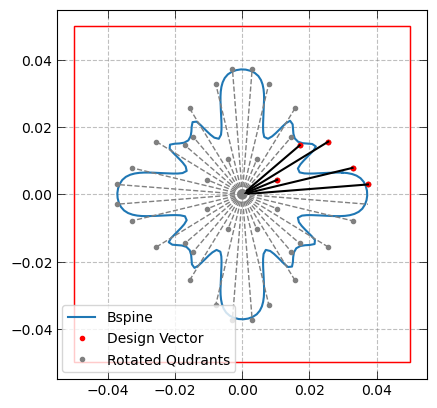


No module named 'trame'

Falling back to a static output.
  warnings.warn(



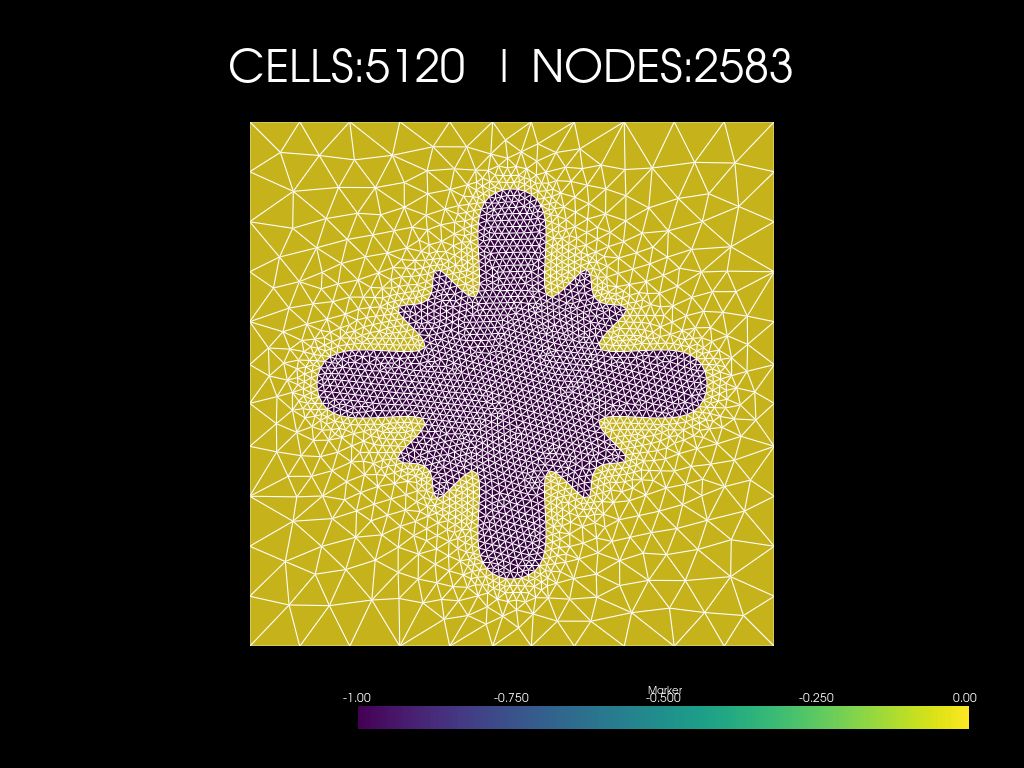

In [12]:

# Meshing parameters
cut         = False
a_len       = .1
r           = np.array([1,.9,.3,.8,.6])*a_len*.75
offset      = 0*np.pi
design_vec  = np.concatenate( (r/a_len, [offset] ))
Nquads      = 8
da                  =   a_len/10
meshalg             =   5
refinement_level    =   7
refinement_dist     =   a_len/6
meshalg                 = 6

# Make the mesh with Gmsh
gmsh.model, xpt, ypt    = get_mesh_SquareSpline(
        a_len, da, r, Nquads, offset, meshalg,
        refinement_level, refinement_dist,
        isrefined = True,   cut = cut
)


# Import to dolfinx and save as xdmf                 
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)

# Plot the design vector and the produced mesh
plt = PlotSpline(gmsh, r, Nquads, a_len, xpt, ypt)
plt.show()
plotmesh(mesh,ct)

Now we convert the gmsh object to a dolfinx mesh. The `model_to_mesh` module returns the mesh in the correct format along with `ct` which account for domain tags constructed in `gmsh`. Thses tags will be needed if assigneing material propeties to multiple domains

Now we set up the physical problem. The quanties are $c$ and $\rho$, for the equation

$$
c^2\nabla u(x,t) - \frac{\partial^2}{\partial t^2}u(x,t) = 0
$$

If the inclusion gemoetry is not a cut out, then ehere are two domains in the unit cell that both need ot be. We also set np1, np2, and np3, which are the number of poitns we visit in k space between the high symmetry points $\Gamma$-$X$-$M$-$\Gamma$

In [51]:
if not cut:
    c           = [1500,5100]   # if solid inclusion (mutlple materail model)
    rho         = [1e3,7e3]     # if solid inclusion (mutlple materail model) 
else:
    c           = [30]          # if void inclusion  (if iscut)
    rho         = [1.2]         # if void inclusion  (if iscut)


np1     = 20
np2     = 20
np3     = 20
nvec    = 20
fspace  = 'CG'

Now we solve the entire band structure using the finite-element method. The following code solves the eigenproblem along  the $\Gamma$-X-M-$\Gamma$ boundary of the IBZ
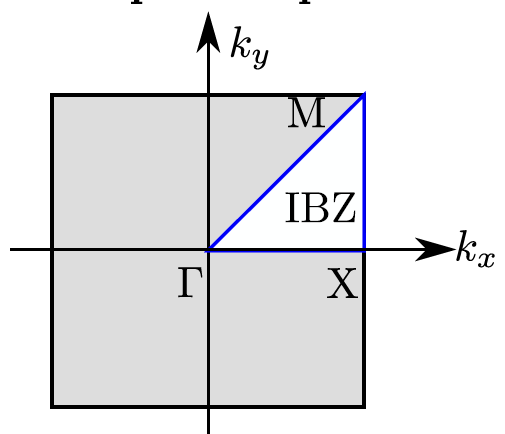

This could be changedby modifying the tuble of high-symmetry points to consider

## Solve on the $\Gamma$-X-M-$\Gamma$ boundary

The default function is `solve_bands`, and this solves around the IBZ for 4-quad rotational symmetry in the unit cell. If this symmetry is broken, you may need to pass over more high-symmetry points, in which case see the next cell to set up a custom IBZ path with `solve_bands_customHS`

In [20]:
evals_disp, evec_all, mpc = solve_bands(
        np1, np2, np3, nvec, a_len, c, rho, fspace, mesh,ct)


MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)
Computing Band Structure... 
Computing Γ to X
Computing X to M
Computing M to Γ
Time to compute dispersion 7.091
Band computation complete
-----------------
N_dof....5120
N_vectors....20
N_wavenumbers....60
T total....7.091


# Visualize the Results
Now we just call the `plotbands()` function from `postprocess` to visual the dispersion curves and band gaps.

In [52]:


# Define the high symmetry points of the lattice
P1 = [0,0]                      # Gamma 
P2 = [np.pi/a_len, 0]           # X
P3 = [np.pi/a_len, np.pi/a_len] # K
P4 = [0, np.pi/a_len]           # Z
HSpts = [P1,P2,P3,P4,P1]


# Define the numnber of eigenvectors to solve for each soltuion
nvec = 20

# Define number of eigensolutions desired
nsol = len(HSpts)*12

evals_disp, evec_all, mpc, KX, KY = solve_bands_customHS(
HSpts  = HSpts,
nsol  = nsol, 
nvec = nvec, 
a_len = a_len, 
c = c, 
rho = rho, 
fspace = fspace, 
mesh = mesh,
ct = ct
)

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)
Computing Band Structure .... 
Computing HS points 1 to 2
Time to compute Dispersion 1.848
Band Compuation Complete
-----------------
N_dof....1346
N_vectors....20
N_wavenumbers....60
T total....1.848


Collect bands and bandgaps

In [21]:
bgnrm, gapwidths, gaps, lowbounds, highbounds = getbands(np.array(evals_disp))

Visual the output

8120.146873150768


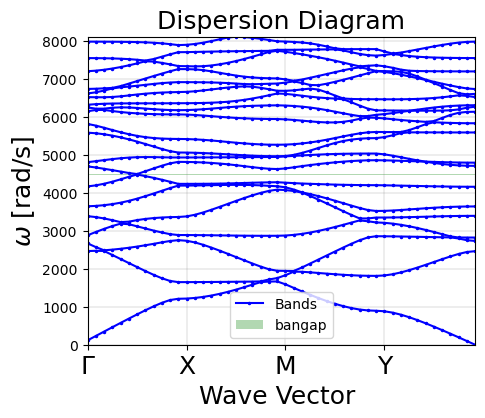

In [53]:
def plotbands(bands,  HSpts, nsol,figsize = (5,4),):
    """
    Plot the disprsion bands with bandgaps highlighted on the G-X-M-G boundary
    """ 
    bgnrm, gapwidths, gaps, lowbounds, highbounds = getbands(bands)

    from matplotlib.patches import Rectangle
    plt.figure(figsize=figsize)
    np1 = 20; np2 = 20; np3 = 20
    nvec_per_HS = int(round(nsol/len(HSpts)))
    xx = []
    start = 0
    for k in range(len(HSpts)-1):
        xx.append(np.linspace(start,start+1-1/nvec_per_HS ,nvec_per_HS))
        start+=1 
    xx = np.array(xx)
    d1,d2 = xx.shape[0],xx.shape[1]
    xx = xx.reshape(d2*d1,)
    nvec = 20

    maxfq = bands.max()
    print(maxfq)
    # PLOT THE DISPERSION BANDS
    for n in range(nvec):
        ev = bands[:,n]
        if n == 0:
            plt.plot( xx,(ev),'b.-',markersize = 3, label = 'Bands')
        else:
            plt.plot( xx,(ev),'b.-',markersize = 3)
    plt.grid(color='gray', linestyle='-', linewidth=0.2)
    plt.xticks(np.array([0,1,2,3,4]), ['$\Gamma$', 'X', 'M','Y', '$\Gamma$'],fontsize=18)
    plt.xlabel(r'Wave Vector ',fontsize=18)
    plt.ylabel('$\omega$ [rad/s]',fontsize=18)
    plt.title('Dispersion Diagram',fontsize = 18)
    plt.xlim((0,np.max(xx)))
    plt.ylim((0,np.max(maxfq)))
    currentAxis = plt.gca()
    for j in range(len(gapwidths)):
        lb = lowbounds[j]
        ub = highbounds[j]
        if j == 0:
            currentAxis.add_patch( Rectangle((np.min(xx),lb), np.max(xx), ub-lb,  facecolor="g" ,ec='none', alpha =.3,label='bangap'))
        else:
            currentAxis.add_patch( Rectangle((np.min(xx),lb), np.max(xx), ub-lb,  facecolor="g" ,ec='none', alpha =.3))
    plt.legend()
    return plt


plt = plotbands(np.array(evals_disp), HSpts, nsol)

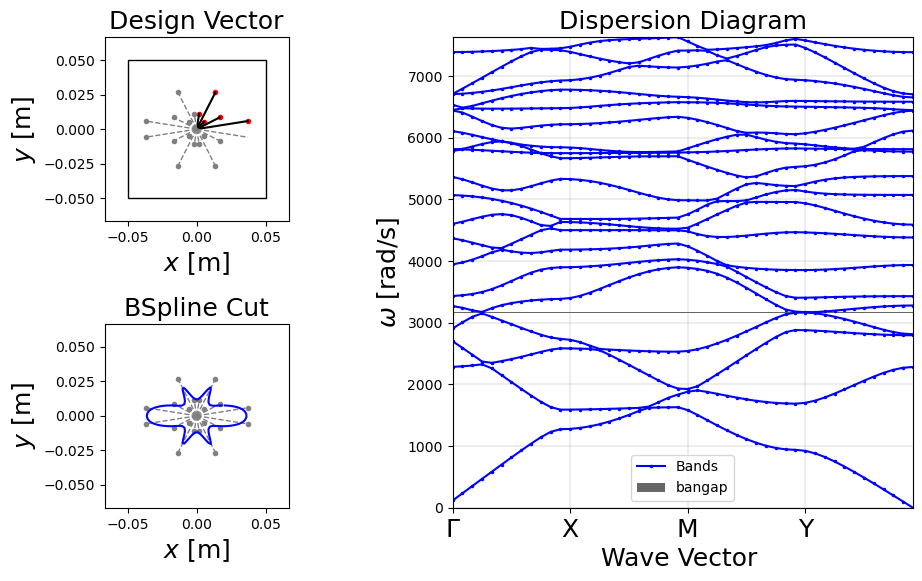

In [40]:
###########################################################
# FIG 2: Plot dispersion with design vec and void tplgy  #
###########################################################
nvec_per_HS = int(round(nsol/len(HSpts)))
xx = []
start = 0
for k in range(len(HSpts)-1):
    xx.append(np.linspace(start,start+1-1/nvec_per_HS ,nvec_per_HS))
    start+=1 
xx = np.array(xx)
d1,d2 = xx.shape[0],xx.shape[1]
xx = xx.reshape(d2*d1,)
node_interior = gmsh.model.mesh.getNodesForPhysicalGroup(1,5)[1]
x_int = node_interior[0::3]
y_int = node_interior[1::3]
x  = np.array(xpt) - a_len/2
y  = np.array(ypt) - a_len/2
xi = x_int - a_len/2
yi = y_int - a_len/2
fig = plt.figure(figsize=(10,6) )
ax1 = fig.add_subplot(1,2,2)
for n in range(nvec):
    ev = []
    for k in range(len(evals_disp)):
        ev.append(np.real(evals_disp[k][n]))
    if n == 0:
        ax1.plot( xx,(ev),'b.-',markersize = 3, label = 'Bands')
    else:
        ax1.plot( xx,(ev),'b.-',markersize = 3)
ax1.grid(color='gray', linestyle='-', linewidth=0.2)
# ax1.set_xticks(np.array([0,1,2,2+np.sqrt(2)]), ['$\Gamma$', 'X', 'M', '$\Gamma$'],fontsize=18)
ax1.set_xticks(np.array([0,1,2,3,4]), ['$\Gamma$', 'X', 'M','Y', '$\Gamma$'],fontsize=18)
ax1.set_xlabel(r'Wave Vector ',fontsize=18)
ax1.set_ylabel('$\omega$ [rad/s]',fontsize=18)
ax1.set_title('Dispersion Diagram',fontsize = 18)
ax1.set_xlim((0,np.max(xx)))
ax1.set_ylim((0,np.max(maxfq)))
for j in range(len(gapwidths)):
    lb = lowbounds[j]
    ub = highbounds[j]
    if j == 0:
        ax1.add_patch( Rectangle((np.min(xx),lb), np.max(xx), ub-lb,  facecolor="k" ,ec='none', alpha =.6,label='bangap'))
    else:
        ax1.add_patch( Rectangle((np.min(xx),lb), np.max(xx), ub-lb,  facecolor="k" ,ec='none', alpha =.6))
ax1.legend()
# =============================
ax2 = fig.add_subplot(221)
ax2.add_patch( Rectangle( (-a_len/2,-a_len/2),a_len,a_len, facecolor="w" ,ec='k', alpha =1,label='bangap'))
ax2.plot(x[0:int(len(xpt)/Nquads)], y[0:int(len(xpt)/Nquads)], ' .r')
ax2.plot(x[int(len(xpt)/Nquads):-1], y[int(len(xpt)/Nquads):-1], '.', color = 'gray')
for j in range(len(xpt)):
    # plt.plot([0,x[r]], [0,y[r]],'k')
    if j<int(len(x)/Nquads):
        ax2.plot([0,x[j]], [0,y[j]],'k')
    else:
        ax2.plot([0,x[j]], [0,y[j]],'--', color = 'gray', linewidth = 1)
ax2.set_title('Design Vector',fontsize = 18)
ax2.set_xlabel('$x$ [m]',fontsize = 18)
ax2.set_ylabel('$y$ [m]',fontsize = 18)
ax2.set_aspect('equal', 'box')
ax2.set_xlim((-a_len/1.5,a_len/1.5))
ax2.set_ylim((-a_len/1.5,a_len/1.5))
# =============================
ax2 = fig.add_subplot(223)
ax2.add_patch( Rectangle( (-a_len/2,-a_len/2),a_len,a_len, facecolor="w" ,ec='w', alpha =.2,label='bangap'))
ax2.plot(x, y, '.', color = 'gray')
for j in range(len(xpt)):
    ax2.plot([0,x[j]], [0,y[j]],'--', color = 'gray', linewidth = 1)
ax2.plot(xi, yi, '-b')
ax2.set_title('BSpline Cut',fontsize = 18)
ax2.set_xlabel('$x$ [m]',fontsize = 18)
ax2.set_ylabel('$y$ [m]',fontsize = 18)
ax2.set_aspect('equal', 'box')
ax2.set_xlim((-a_len/1.5,a_len/1.5))
ax2.set_ylim((-a_len/1.5,a_len/1.5))
# =============================
fig.tight_layout(pad=1.4)
plt.show()
###########################################################

  mycmap = plt.cm.get_cmap('seismic', 10)




No module named 'trame'

Falling back to a static output.
  warnings.warn(



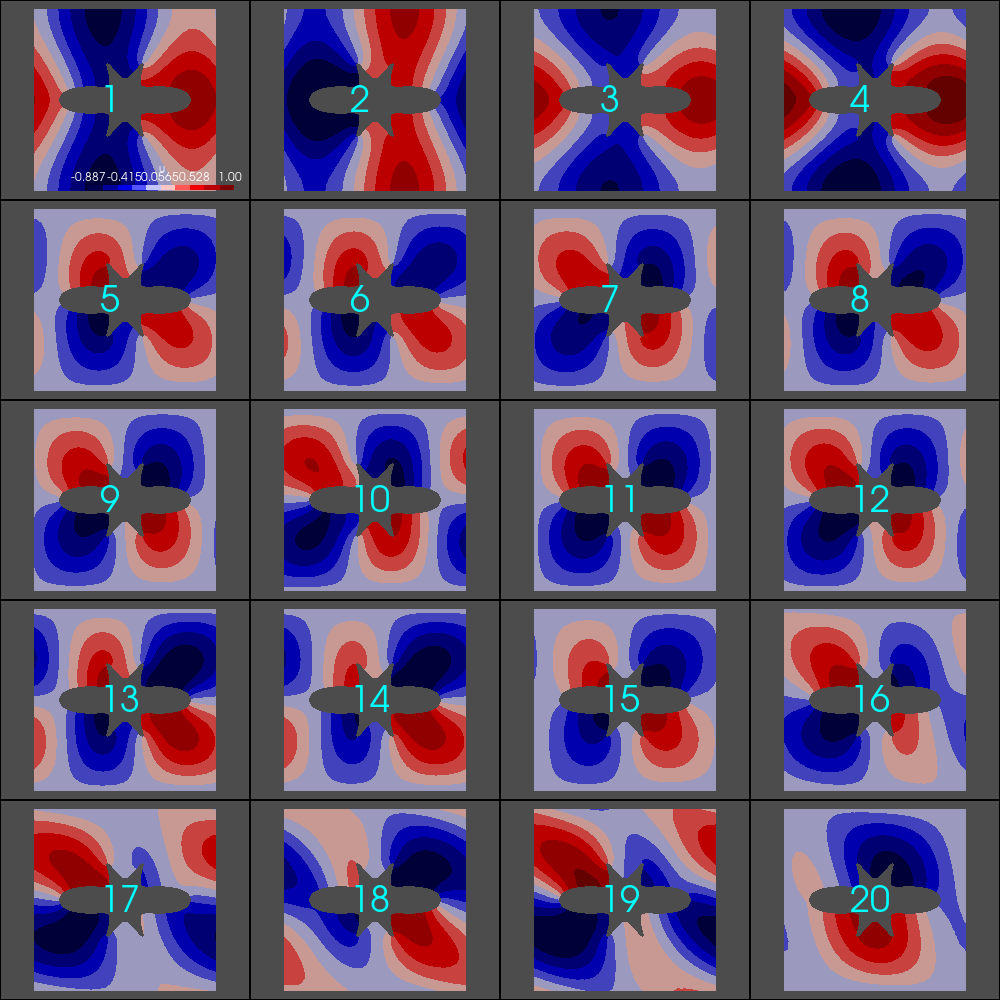

In [24]:
testload = np.array(evec_all) #np.load('data//testFile.npy')
plotter = pyvista.Plotter(shape=(5,4) , window_size=(1000,1000))
###########################################################
# Post-processing the eigenvectors
###########################################################
euse = 0
for i in range(5):
    for j in range(4):
        plotter.subplot(i,j)
        et = testload[euse,:,3]; euse += 1
        vr = Function(V)
        vi = Function(V)
        vr.vector[:] = np.real(et)
        vi.vector[:] = np.imag(et)
        vr.x.scatter_forward()
        mpc.backsubstitution(vr.vector)
        vi.x.scatter_forward()
        mpc.backsubstitution(vi.vector)


        ###########################################################
        # Plotting eigenvectors with pyvista
        ###########################################################
        # mycmap = plt.cm.get_cmap('coolwarm', 10)
        mycmap = plt.cm.get_cmap('seismic', 10)
        u = Function(V)
        cells, types, x = plot.create_vtk_mesh(V)
        grid = pyvista.UnstructuredGrid(cells, types, x)
        grid.point_data["u"] = u.x.array
        u.vector.setArray(vr.vector[:]/np.max(vr.vector[:])*np.sign(vr.vector[10]))
        edges = grid.extract_all_edges()
        warped = grid.warp_by_scalar("u", factor=0)
        plotter.add_mesh(warped, show_edges=False, show_scalar_bar=True, scalars="u",cmap=mycmap)
        # plotter.add_mesh(grid, style = 'wireframe', line_width = .5, color = 'black')
        plotter.view_xy()
        plotter.add_text(str(euse), position=[100,80], color='cyan')
        plotter.camera.tight(padding=0.1)

plotter.show()